In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path

data_folder = Path("../../data")

prod_data_folder: Path = data_folder.joinpath("30_prod/")
model_artifact = Path("../../models/artifacts")

In [3]:
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({"figure.figsize": (8, 6)})

GENERATOR_KEYWORD: str = "GENERATOR"
DISCRIMINATOR_KEYWORD: str = "DISCRIMINATOR"

MODEL_TYPE: str = "GAN_ATTENTION"

AAPL_TICKER: str = "AAPL"
ACWI_TICKER: str = "ACWI"
JPM_TICKER: str = "JPM"

aapl_stock_filename: str = f"{AAPL_TICKER}.csv"
acwi_stock_filename: str = f"{ACWI_TICKER}.csv"
jpm_stock_filename: str = f"{JPM_TICKER}.csv"

aapl_df: pd.DataFrame = pd.read_csv(prod_data_folder.joinpath(aapl_stock_filename))
acwi_df: pd.DataFrame = pd.read_csv(prod_data_folder.joinpath(acwi_stock_filename))
jpm_df: pd.DataFrame = pd.read_csv(prod_data_folder.joinpath(jpm_stock_filename))

aapl_df["Date"] = pd.to_datetime(aapl_df["Date"], format="%Y-%m-%d")
acwi_df["Date"] = pd.to_datetime(acwi_df["Date"], format="%Y-%m-%d")
jpm_df["Date"] = pd.to_datetime(jpm_df["Date"], format="%Y-%m-%d")

aapl_min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
acwi_min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
jpm_min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

aapl_min_max_scaler.fit(aapl_df[["Close"]])
acwi_min_max_scaler.fit(acwi_df[["Close"]])
jpm_min_max_scaler.fit(jpm_df[["Close"]])

MinMaxScaler(feature_range=(-1, 1))

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, seq_length = x.size()
        proj_query = (
            self.query_conv(x).view(batch_size, -1, seq_length).permute(0, 2, 1)
        )
        proj_key = self.key_conv(x).view(batch_size, -1, seq_length)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, seq_length)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = self.gamma * out + x
        return out


class Generator(nn.Module):
    def __init__(self, latent_dim, seq_length=60, n_features=1):
        super(Generator, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.init_length = seq_length // 4
        self.init_channels = 128

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, self.init_channels * self.init_length),
            nn.BatchNorm1d(self.init_channels * self.init_length),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose1d(
                self.init_channels, 64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.attn = SelfAttention(64)

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose1d(64, n_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(z.size(0), self.init_channels, self.init_length)
        out = self.deconv1(out)
        out = self.attn(out)
        out = self.deconv2(out)
        return out.permute(0, 2, 1)


class Discriminator(nn.Module):
    def __init__(self, seq_length=60, n_features=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
        )

        self.attn = SelfAttention(128)

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attn(x)
        x = self.conv3(x)
        validity = self.fc(x)
        return validity

### Apple

In [5]:
aapl_generator_model_filename: str = (
    f"{GENERATOR_KEYWORD}_{MODEL_TYPE}_{AAPL_TICKER}.pth"
)
aapl_discriminator_model_filename: str = (
    f"{DISCRIMINATOR_KEYWORD}_{MODEL_TYPE}_{AAPL_TICKER}.pth"
)

aapl_generator = Generator(100)
aapl_discriminator = Discriminator()

aapl_generator.load_state_dict(
    torch.load(model_artifact / aapl_generator_model_filename)
)
aapl_discriminator.load_state_dict(
    torch.load(model_artifact / aapl_discriminator_model_filename)
)

<All keys matched successfully>

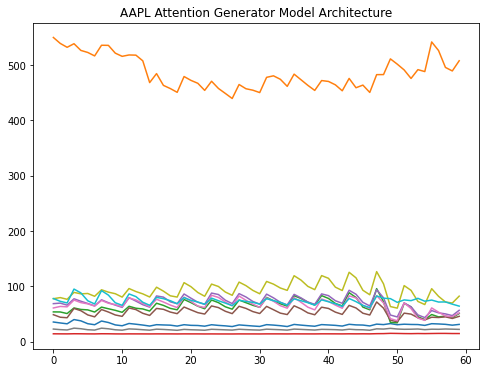

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

aapl_generator.eval()

with torch.no_grad():
    input_tensor = torch.randn(10, 1, 100)
    for i in range(10):
        output_tensor = aapl_generator(input_tensor[i])
        ax.plot(
            aapl_min_max_scaler.inverse_transform(output_tensor[0].numpy()),
            label=f"Sample {i}",
        )

ax.set_title("AAPL Attention Generator Model Architecture")
plt.show()

### ACWI

In [7]:
acwi_generator_model_filename: str = (
    f"{GENERATOR_KEYWORD}_{MODEL_TYPE}_{ACWI_TICKER}.pth"
)
acwi_discriminator_model_filename: str = (
    f"{DISCRIMINATOR_KEYWORD}_{MODEL_TYPE}_{ACWI_TICKER}.pth"
)

acwi_generator = Generator(100)
acwi_discriminator = Discriminator()

acwi_generator.load_state_dict(
    torch.load(model_artifact / acwi_generator_model_filename)
)
acwi_discriminator.load_state_dict(
    torch.load(model_artifact / acwi_discriminator_model_filename)
)

<All keys matched successfully>

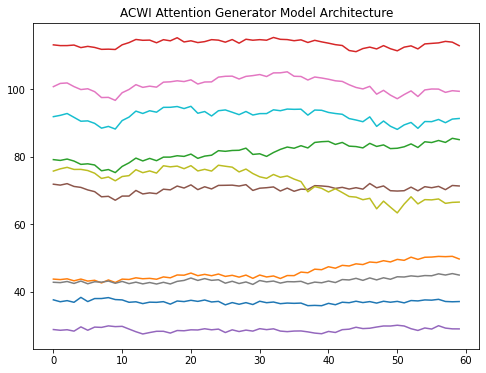

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

acwi_generator.eval()

with torch.no_grad():
    input_tensor = torch.randn(10, 1, 100)
    for i in range(10):
        output_tensor = acwi_generator(input_tensor[i])
        ax.plot(
            acwi_min_max_scaler.inverse_transform(output_tensor[0].numpy()),
            label=f"Sample {i}",
        )

ax.set_title("ACWI Attention Generator Model Architecture")
plt.show()

### JPM

In [9]:
jpm_generator_model_filename: str = f"{GENERATOR_KEYWORD}_{MODEL_TYPE}_{JPM_TICKER}.pth"
jpm_discriminator_model_filename: str = (
    f"{DISCRIMINATOR_KEYWORD}_{MODEL_TYPE}_{JPM_TICKER}.pth"
)

jpm_generator = Generator(100)
jpm_discriminator = Discriminator()

jpm_generator.load_state_dict(torch.load(model_artifact / jpm_generator_model_filename))
jpm_discriminator.load_state_dict(
    torch.load(model_artifact / jpm_discriminator_model_filename)
)

<All keys matched successfully>

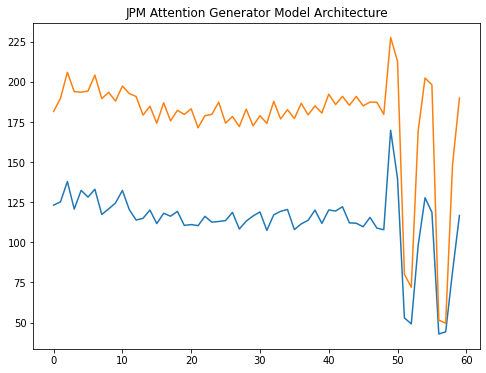

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

jpm_generator.eval()

with torch.no_grad():
    input_tensor = torch.randn(2, 1, 100)
    for i in range(2):
        output_tensor = jpm_generator(input_tensor[i])
        ax.plot(
            jpm_min_max_scaler.inverse_transform(output_tensor[0].numpy()),
            label=f"Sample {i}",
        )

ax.set_title("JPM Attention Generator Model Architecture")
plt.show()

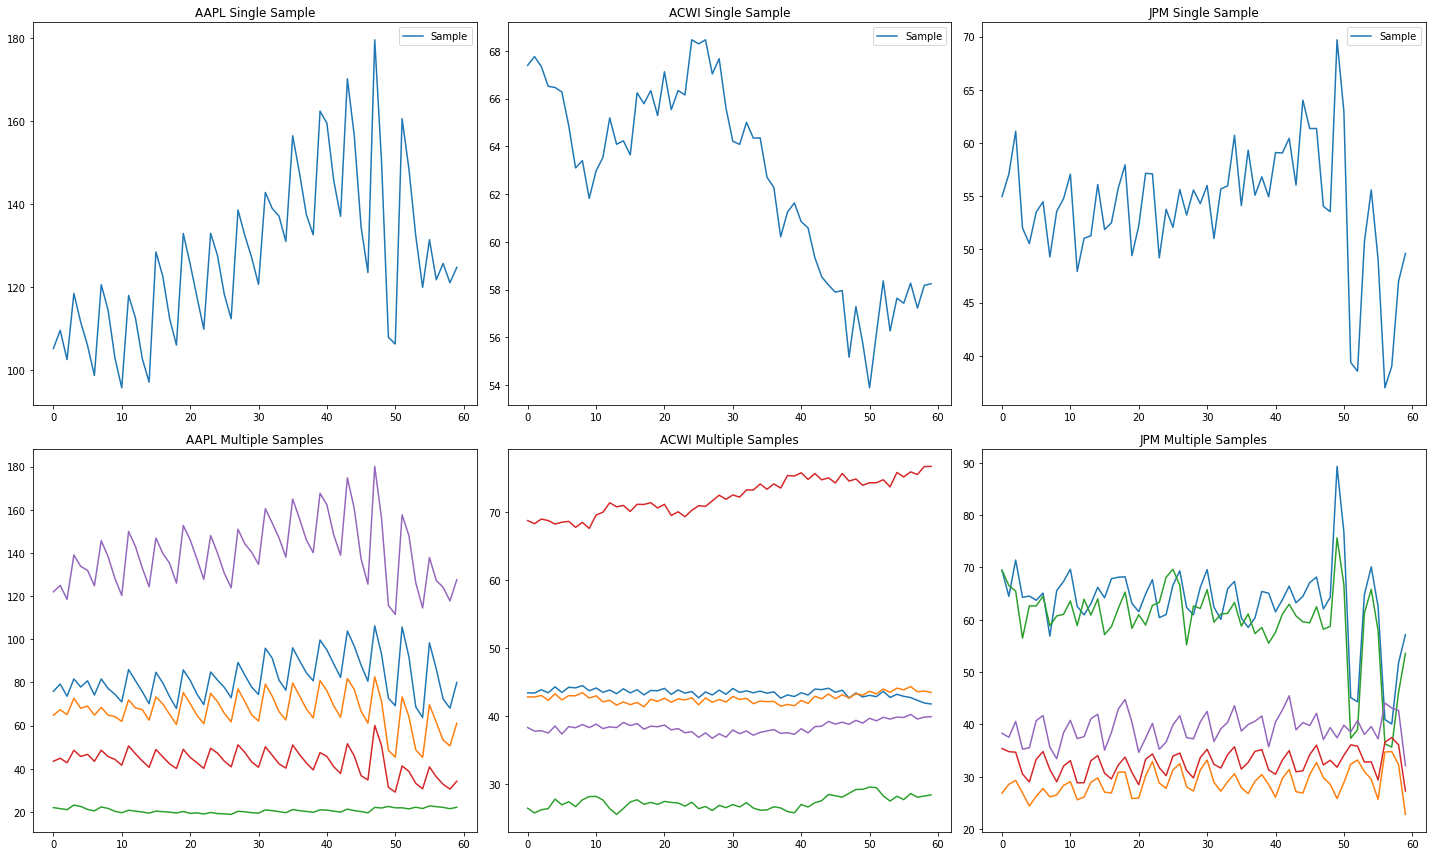

In [18]:
n_samples_single = 1
n_samples_multiple = 5
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

tickers = [
    (AAPL_TICKER, aapl_generator, aapl_min_max_scaler),
    (ACWI_TICKER, acwi_generator, acwi_min_max_scaler),
    (JPM_TICKER, jpm_generator, jpm_min_max_scaler)
]

# First row - single sample
for idx, (ticker, generator, scaler) in enumerate(tickers):
    ax = fig.add_subplot(gs[0, idx])
    
    generator.eval()
    with torch.no_grad():
        input_tensor = torch.randn(n_samples_single, 1, 100)
        output_tensor = generator(input_tensor[0])
        ax.plot(
            scaler.inverse_transform(output_tensor[0].numpy()),
            label=f"Sample"
        )
    
    ax.set_title(f"{ticker} Single Sample")
    ax.legend()

# Second row - multiple samples
for idx, (ticker, generator, scaler) in enumerate(tickers):
    ax = fig.add_subplot(gs[1, idx])
    
    generator.eval()
    with torch.no_grad():
        input_tensor = torch.randn(n_samples_multiple, 1, 100)
        for i in range(n_samples_multiple):
            output_tensor = generator(input_tensor[i])
            ax.plot(
                scaler.inverse_transform(output_tensor[0].numpy()),
                label=f"Sample {i+1}"
            )
    
    ax.set_title(f"{ticker} Multiple Samples")

plt.tight_layout()
plt.show()


AAPL Moments Comparison:
Metric                   Original    Generated
------------------------------------
Mean................     0.000128    -0.000002
Std.................     0.040645     0.214407
Skewness............   -25.111799     0.255764
Kurtosis............  1039.042700    46.728140
Ljung-Box t-stat....    10.673040 272346.309774
Ljung-Box p-value...     0.383552     0.000000
Jensen-Shannon Divergence: 0.580034

ACWI Moments Comparison:
Metric                   Original    Generated
------------------------------------
Mean................     0.000279     0.000001
Std.................     0.012906     0.079548
Skewness............    -0.556542    -0.786310
Kurtosis............    11.866263   135.567522
Ljung-Box t-stat....    55.307795  1234.989861
Ljung-Box p-value...     0.000000     0.000000
Jensen-Shannon Divergence: 0.221720

JPM Moments Comparison:
Metric                   Original    Generated
------------------------------------
Mean................     0.000189 

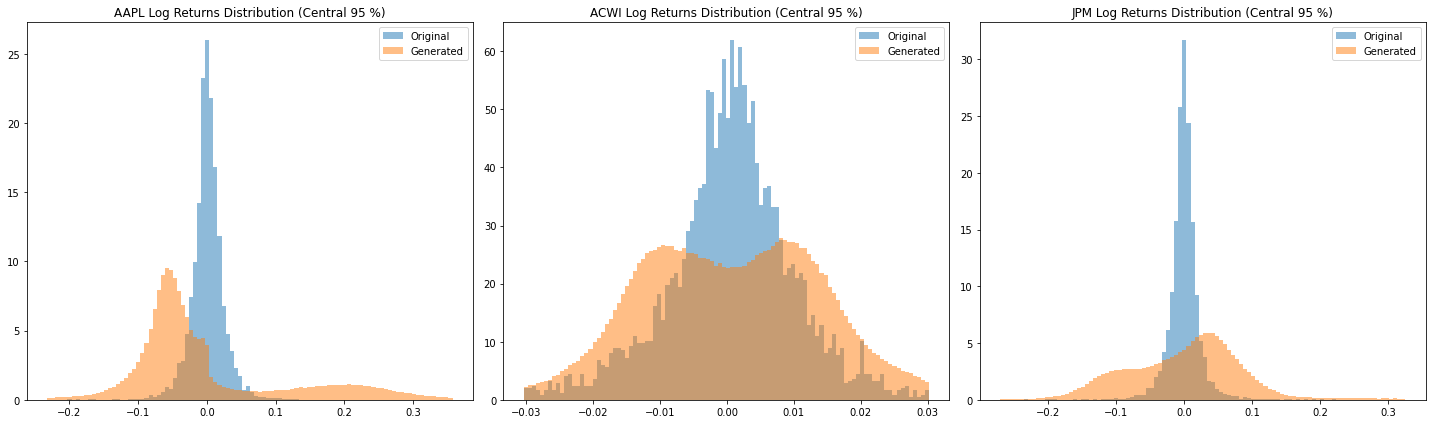

In [11]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.spatial.distance import jensenshannon
from statsmodels.stats.diagnostic import acorr_ljungbox

n_samples: int = 10_000


def calculate_log_returns(prices):
    return np.log(prices[1:]) - np.log(prices[:-1])


def get_moments(returns):
    mean = np.mean(returns)
    std = np.std(returns)
    skewness = skew(returns)
    kurt = kurtosis(returns)
    return mean, std, skewness, kurt


def get_autocorrelation_test(returns, lag: int = 10):
    return acorr_ljungbox(returns, lags=[lag], return_df=True)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

tickers = [
    (AAPL_TICKER, aapl_generator, aapl_min_max_scaler, ax1),
    (ACWI_TICKER, acwi_generator, acwi_min_max_scaler, ax2),
    (JPM_TICKER, jpm_generator, jpm_min_max_scaler, ax3),
]

for ticker, generator, scaler, ax in tickers:
    df = pd.read_csv(prod_data_folder.joinpath(f"{ticker}.csv"))
    orig_returns = calculate_log_returns(df["Close"].values)

    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n_samples, 1, 100)
        generated = []
        for n in noise:
            output = generator(n)
            generated.append(scaler.inverse_transform(output[0].numpy()))

    generated = np.array(generated).reshape(-1)
    gen_returns = calculate_log_returns(generated)

    orig_low, orig_high = np.percentile(orig_returns, [2.5, 97.5])
    gen_low, gen_high = np.percentile(gen_returns, [2.5, 97.5])

    plot_low = min(orig_low, gen_low)
    plot_high = max(orig_high, gen_high)

    ax.hist(
        orig_returns,
        bins=100,
        range=(plot_low, plot_high),
        alpha=0.5,
        label="Original",
        density=True,
    )
    ax.hist(
        gen_returns,
        bins=100,
        range=(plot_low, plot_high),
        alpha=0.5,
        label="Generated",
        density=True,
    )
    ax.set_title(f"{ticker} Log Returns Distribution (Central 95 %)")
    ax.legend()

    orig_moments = get_moments(orig_returns)
    gen_moments = get_moments(gen_returns)
    orig_autocorrelation_test = get_autocorrelation_test(orig_returns)
    gen_autocorrelation_test = get_autocorrelation_test(gen_returns)

    print(f"\n{ticker} Moments Comparison:")
    print(f"{'Metric':<20} {'Original':>12} {'Generated':>12}")
    print("-" * 36)
    print(f"{'Mean':.<20} {orig_moments[0]:>12.6f} {gen_moments[0]:>12.6f}")
    print(f"{'Std':.<20} {orig_moments[1]:>12.6f} {gen_moments[1]:>12.6f}")
    print(f"{'Skewness':.<20} {orig_moments[2]:>12.6f} {gen_moments[2]:>12.6f}")
    print(f"{'Kurtosis':.<20} {orig_moments[3]:>12.6f} {gen_moments[3]:>12.6f}")
    print(
        f"{'Ljung-Box t-stat':.<20} {orig_autocorrelation_test.lb_stat.item():>12.6f} {gen_autocorrelation_test.lb_stat.item():>12.6f}"
    )
    print(
        f"{'Ljung-Box p-value':.<20} {orig_autocorrelation_test.lb_pvalue.item():>12.6f} {gen_autocorrelation_test.lb_pvalue.item():>12.6f}"
    )

    hist_orig, bins = np.histogram(
        orig_returns, bins=50, range=(plot_low, plot_high), density=True
    )
    hist_gen, _ = np.histogram(gen_returns, bins=bins, density=True)

    hist_orig = hist_orig + 1e-10
    hist_gen = hist_gen + 1e-10
    hist_orig = hist_orig / hist_orig.sum()
    hist_gen = hist_gen / hist_gen.sum()

    js_div = jensenshannon(hist_orig, hist_gen)
    print(f"Jensen-Shannon Divergence: {js_div:.6f}")

plt.tight_layout()
plt.show()